# E-commerce Sales Analysis


#### Import libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly
import random
import calendar
from datetime import datetime
from  IPython.display import display
# from scipy.interpolate import make_interp_spline, BSpline

import json
from urllib.request import urlopen


#### Multi-output

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

#### Display full columns

In [3]:
pd.set_option('display.max_columns', None)

### Dataset Overview

In [4]:
df = pd.read_csv("ecom_data(full).csv")
df.head()

,order_id,customer_id,quantity,price_MRP,payment,timestamp,rating,product_category,product_id,payment_type,order_status,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_id,seller_state,payment_installments
0,9045fa841de3514ce900f5fc869d9b1f,2f8d6af8cb3875d6964eb4b5eff3a718,18,1074.38,1095.65,21-11-2017 22:34,5,health_beauty,0a37e05528984f47c754837344732fbb,credit_card,delivered,800,40,20,30,SP,ccc4bbb5f32a6ab2b7066a4130f114e3,PR,22
1,404c087c1f661898fcfe9d4c4b1480d7,1ce70910bc16481433b771949f74552c,7,145.00,161.71,24-02-2017 22:55,5,health_beauty,67473aa97e981b3b8abaa6a8a768eb26,credit_card,delivered,400,38,12,25,RJ,ccc4bbb5f32a6ab2b7066a4130f114e3,PR,23
2,d6d7c431275f0029dcc3538850930046,5b477d525dd0c1eb93148e22ce5d3ba6,11,145.00,161.71,19-01-2017 14:28,4,health_beauty,67473aa97e981b3b8abaa6a8a768eb26,credit_card,delivered,400,38,12,25,RJ,ccc4bbb5f32a6ab2b7066a4130f114e3,PR,20
3,c0e02613bf15378f18d3498361a76c9d,c2f181778a12039532d79460d4ba59e2,12,555.00,585.95,1/6/2018 22:22,4,health_beauty,b60a0c8bd0333c69ee70565973709bbf,boleto,delivered,650,16,10,11,RO,ccc4bbb5f32a6ab2b7066a4130f114e3,PR,10
4,1bf38e3450f15beeafbebe6e0665d612,21a9772e10934cf4598522d6ec827697,8,226.80,250.32,15-06-2018 20:36,5,health_beauty,08462528607b71ea62cbc019d91b001e,credit_card,delivered,650,16,10,11,MG,ccc4bbb5f32a6ab2b7066a4130f114e3,PR,18


In [5]:
df.describe()

,quantity,price_MRP,payment,rating,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_installments
count,97254.000000,97254.000000,97254.000000,97254.000000,97254.000000,97254.000000,97254.000000,97254.000000,97254.000000
mean,13.646123,125.957733,158.127588,4.092068,2106.960146,30.144611,16.504308,23.067648,15.415572
std,4.930224,190.721701,217.893948,1.341565,3765.445686,16.140921,13.341868,11.747785,6.419760
min,1.000000,0.850000,0.010000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000
25%,10.000000,41.900000,60.100000,4.000000,300.000000,18.000000,8.000000,15.000000,11.000000
50%,15.000000,79.000000,103.260000,5.000000,700.000000,25.000000,13.000000,20.000000,17.000000
75%,18.000000,139.900000,175.640000,5.000000,1813.000000,38.000000,20.000000,30.000000,21.000000
max,20.000000,6735.000000,13664.080000,5.000000,40425.000000,105.000000,105.000000,118.000000,24.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97254 entries, 0 to 97253
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              97254 non-null  object 
 1   customer_id           97254 non-null  object 
 2   quantity              97254 non-null  int64  
 3   price_MRP             97254 non-null  float64
 4   payment               97254 non-null  float64
 5   timestamp             97254 non-null  object 
 6   rating                97254 non-null  int64  
 7   product_category      97254 non-null  object 
 8   product_id            97254 non-null  object 
 9   payment_type          97254 non-null  object 
 10  order_status          97254 non-null  object 
 11  product_weight_g      97254 non-null  int64  
 12  product_length_cm     97254 non-null  int64  
 13  product_height_cm     97254 non-null  int64  
 14  product_width_cm      97254 non-null  int64  
 15  customer_state     

### Cleaning and preparing data

#### Datetime format

In [7]:
df['timestamp'] = df["timestamp"].apply(lambda date : str(date).replace('/','-'))
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M')

#### Create the state map and its convert func

In [8]:
df_state_customer_interpret = pd.DataFrame({"customer_state":['AC','AL','AM','AP','BA','CE','DF','ES','GO','MA','MG','MS','MT','PA','PB','PE','PI','PR','RJ','RN','RO','RR','RS','SC','SE','SP','TO'],
                                            "full_state": ['Acre','Alagoas','Amazonas','Amapá','Bahia','Ceará','Distrito Federal','Espírito Santo','Goiás','Maranhão','Minas Gerais','Mato Grosso do Sul ','Mato Grosso','Pará','Paraíba','Pernambuco','Piauí','Paraná','Rio de Janeiro','Rio Grande do Norte','Rondônia','Roraima','Rio Grande do Sul  ','Santa Catarina','Sergipe','São Paulo','Tocantins']})
df_state_seller_interpret = pd.DataFrame({"seller_state":['AC','AL','AM','AP','BA','CE','DF','ES','GO','MA','MG','MS','MT','PA','PB','PE','PI','PR','RJ','RN','RO','RR','RS','SC','SE','SP','TO'],
                                            "full_state": ['Acre','Alagoas','Amazonas','Amapá','Bahia','Ceará','Distrito Federal','Espírito Santo','Goiás','Maranhão','Minas Gerais','Mato Grosso do Sul ','Mato Grosso','Pará','Paraíba','Pernambuco','Piauí','Paraná','Rio de Janeiro','Rio Grande do Norte','Rondônia','Roraima','Rio Grande do Sul  ','Santa Catarina','Sergipe','São Paulo','Tocantins']})
df_state_interpret = pd.DataFrame({"state":['AC','AL','AM','AP','BA','CE','DF','ES','GO','MA','MG','MS','MT','PA','PB','PE','PI','PR','RJ','RN','RO','RR','RS','SC','SE','SP','TO'],
                                            "full_state": ['Acre','Alagoas','Amazonas','Amapá','Bahia','Ceará','Distrito Federal','Espírito Santo','Goiás','Maranhão','Minas Gerais','Mato Grosso do Sul ','Mato Grosso','Pará','Paraíba','Pernambuco','Piauí','Paraná','Rio de Janeiro','Rio Grande do Norte','Rondônia','Roraima','Rio Grande do Sul  ','Santa Catarina','Sergipe','São Paulo','Tocantins']})

def ConvertState(eri, cus=None) -> pd.Series:
    """
        This function `ConvertState` takes two parameters `eri` and `cus`. 
        It is designed to convert state abbreviations to full state names based on whether the input is related to customers or sellers.

        Example ConvertState(df.loc[::5000,'customer_state'], cus=True)
    """
    if(cus):
        return pd.merge(df_state_customer_interpret, eri, on='customer_state', how='inner')['full_state']
    elif(cus==None) :
        return pd.merge(df_state_interpret, eri, on='state', how='inner')['full_state']
    else :
        return pd.merge(df_state_seller_interpret, eri, on='seller_state', how='inner')['full_state']


#### Normalize product category and payment types

In [9]:
df['product_category'] = df['product_category'].str.replace('_', ' ')
df['payment_type'] = df['payment_type'].str.replace('_', ' ')

#### Rename columns

In [10]:
df.rename(columns={'product_category': 'category',
                   'product_weight_g' : 'weight(kg)',
                   'product_length_cm' : 'length(cm)',
                   'product_height_cm' : 'height(cm)',
                   'product_width_cm' : 'width(cm)'
                   },inplace=True)

#### Convert product weight g -> kg

In [11]:
df['weight(kg)'] = df['weight(kg)'] / 1000

#### Normalize and reduce id from 32 -> 11 hashed chars

In [12]:
df['order_id'] = df['order_id'].str[::3]
df['customer_id'] = df['customer_id'].str[::3]
df['product_id'] = df['product_id'].str[::3]
df['seller_id'] = df['seller_id'].str[::3]
df.head()

,order_id,customer_id,quantity,price_MRP,payment,timestamp,rating,category,product_id,payment_type,order_status,weight(kg),length(cm),height(cm),width(cm),customer_state,seller_id,seller_state,payment_installments
0,958d5c058d1,2dfb7644e31,18,1074.38,1095.65,2017-11-21 22:34:00,5,health beauty,0758475343b,credit card,delivered,0.80,40,20,30,SP,c4b3620a31e,PR,22
1,4c7f18fd44d,171c44b1942,7,145.00,161.71,2017-02-24 22:55:00,5,health beauty,67ae1bb6a82,credit card,delivered,0.40,38,12,25,RJ,c4b3620a31e,PR,23
2,d73709c3534,575dcb1ecda,11,145.00,161.71,2017-01-19 14:28:00,4,health beauty,67ae1bb6a82,credit card,delivered,0.40,38,12,25,RJ,c4b3620a31e,PR,20
3,c01f3fd9679,c17a05d4dae,12,555.00,585.95,2018-06-01 22:22:00,4,health beauty,ba80397670b,boleto,delivered,0.65,16,10,11,RO,c4b3620a31e,PR,10
4,13305ebe051,29204482e29,8,226.80,250.32,2018-06-15 20:36:00,5,health beauty,06207ac0db1,credit card,delivered,0.65,16,10,11,MG,c4b3620a31e,PR,18


#### New dataset

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97254 entries, 0 to 97253
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   order_id              97254 non-null  object        
 1   customer_id           97254 non-null  object        
 2   quantity              97254 non-null  int64         
 3   price_MRP             97254 non-null  float64       
 4   payment               97254 non-null  float64       
 5   timestamp             97254 non-null  datetime64[ns]
 6   rating                97254 non-null  int64         
 7   category              97254 non-null  object        
 8   product_id            97254 non-null  object        
 9   payment_type          97254 non-null  object        
 10  order_status          97254 non-null  object        
 11  weight(kg)            97254 non-null  float64       
 12  length(cm)            97254 non-null  int64         
 13  height(cm)      

###  Exploratory Data Analysis

#### Distribution of quantitative variables (numerical data)

In [14]:

quantitative = [c for c in df.columns if df.dtypes[c] != 'object']
quantitative.remove('timestamp')
quantitative.remove('payment_installments')
quantitative.remove('rating')
quantitative.remove('quantity')
quantitative


['price_MRP', 'payment', 'weight(kg)', 'length(cm)', 'height(cm)', 'width(cm)']

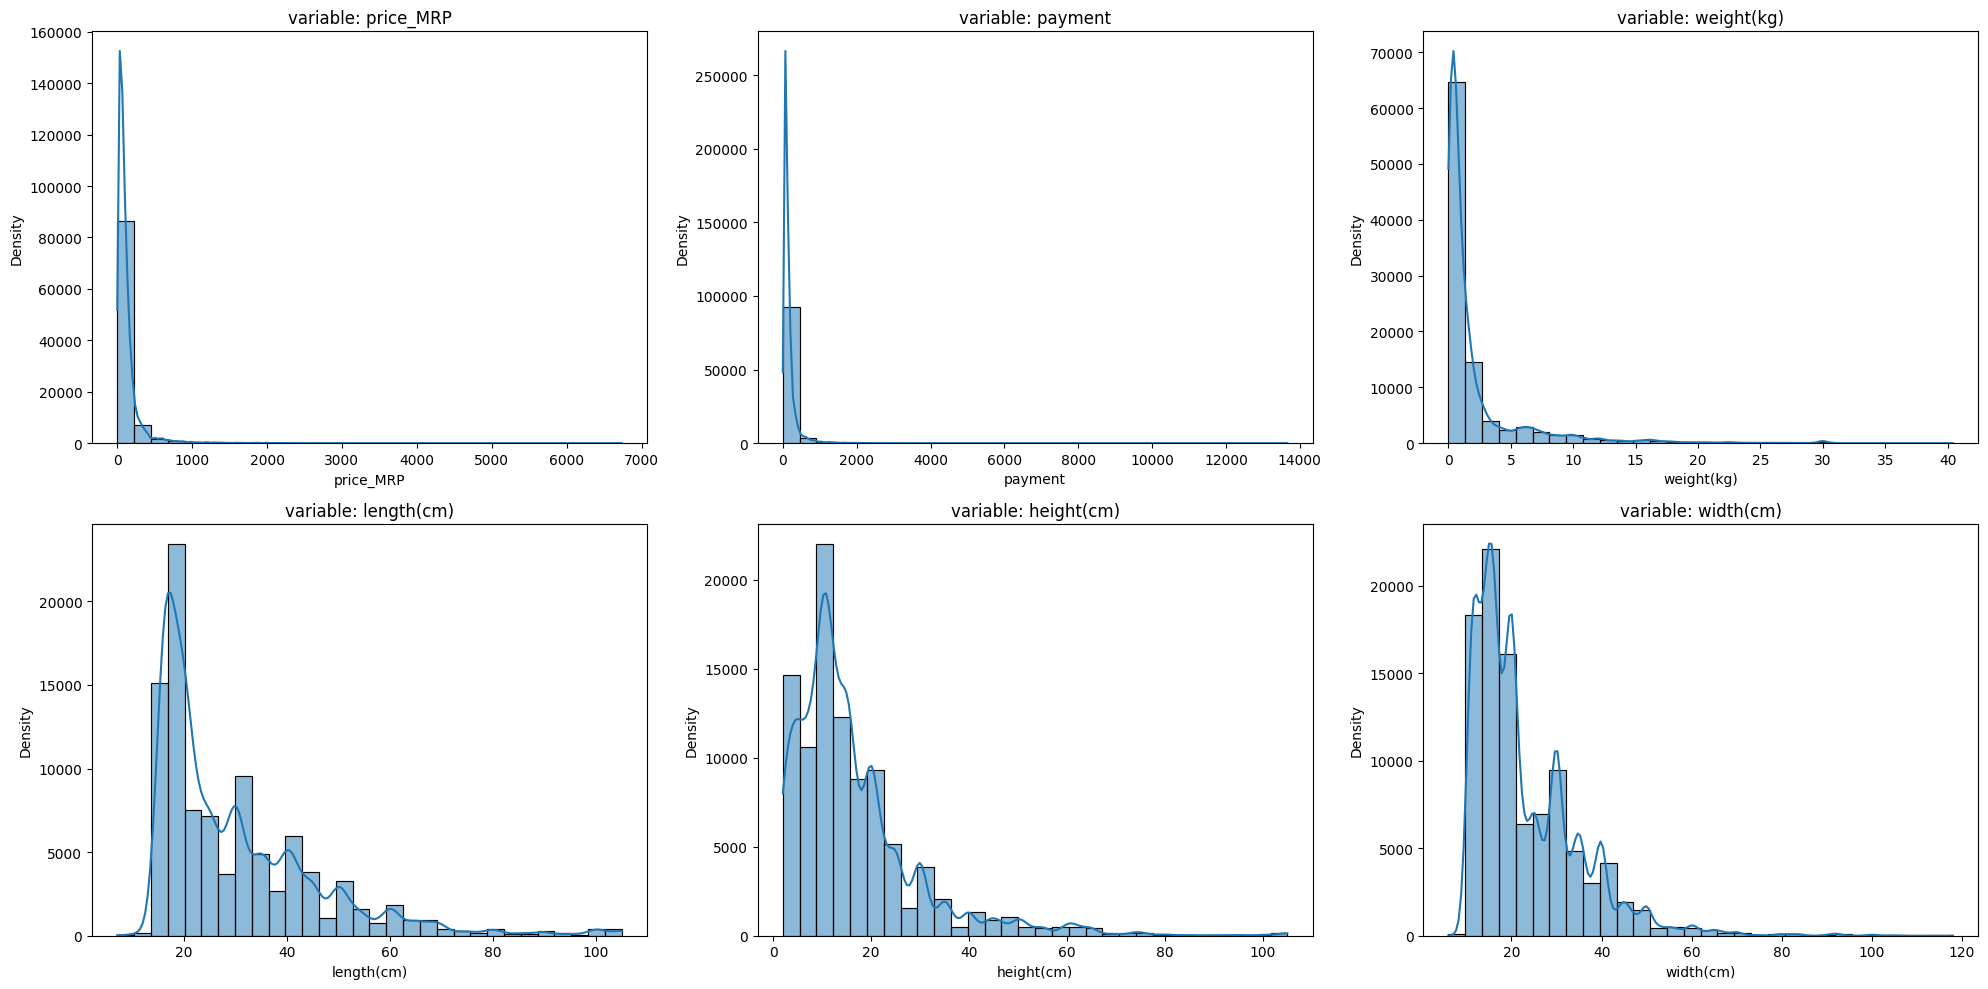

In [15]:

rows, cols = 2,3

plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, col in enumerate(quantitative):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(data=df, x=col, kde=True,bins=30,  edgecolor='black')
    plt.xlabel(col)  
    plt.ylabel('Density')  
    plt.title(f'variable: {col}')  

plt.tight_layout()
plt.show()


#### Distribution of qualitative variables (categorical data)

In [16]:

qualitative = [c for c in df.columns if df.dtypes[c] == 'object']
qualitative = list(filter(lambda  x: not str(x).__contains__('id'), qualitative))
qualitative.append('payment_installments')
qualitative.append('rating')
qualitative


['category',
 'payment_type',
 'order_status',
 'customer_state',
 'seller_state',
 'payment_installments',
 'rating']

##### Rating, payment type and order  status

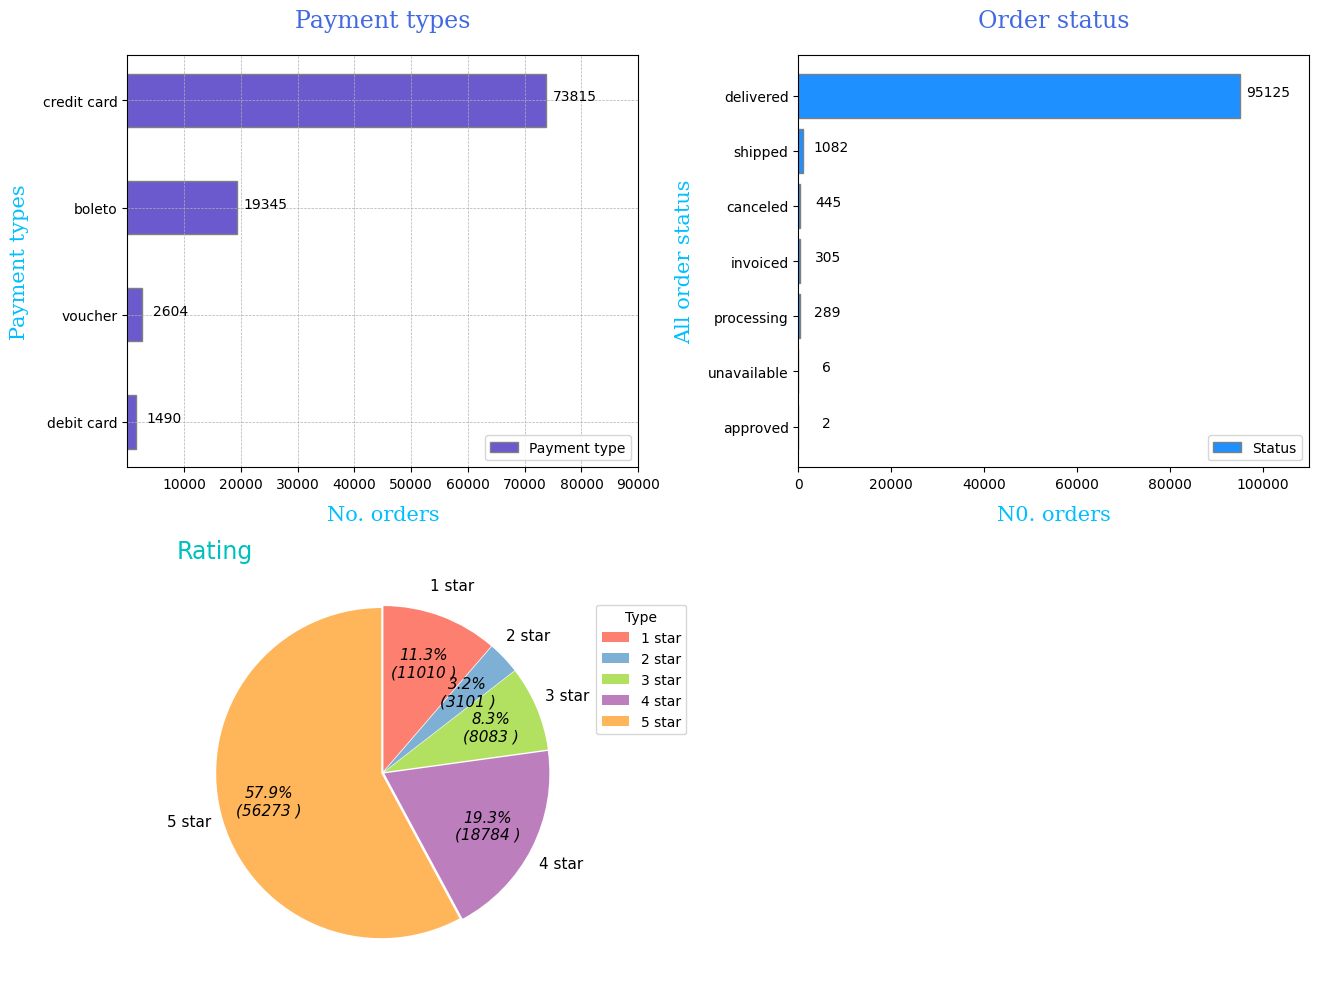

In [17]:

rows, cols = 2,3

plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(rows, cols, 4)
# region Plot 1 for rating

labels = ['1 star', '2 star', '3 star', '4 star', '5 star']

title ="Rating"
rating = df['rating'].value_counts().sort_index().to_frame()
data = rating['count'].values

Spring_Pastels = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

tuple = plt.pie(
    x=data, 
    labels=labels,

    autopct=lambda pct: func(pct, data),
    # autopct='%1.2f%%', # show percentage with two decimal points
    textprops={'fontsize':11}, # increase the size of all text elements 
    colors=Spring_Pastels[:len(data)],

    startangle=90, 
    counterclock=False,
    
    labeldistance=1.2,
    pctdistance=0.7,

    explode = list(map(lambda x : x if (x < 0.15) else 0.01, np.random.random(len(data))))
)

for text in tuple[1]: #texts
    text.set_fontweight('regular')
    text.set_horizontalalignment('center')

for auto_text in tuple[2]: # Autotexts
    auto_text.set_horizontalalignment('center')
    auto_text.set_fontstyle('italic')

plt.legend(tuple[0], labels,
        title="Type",
        loc="center left",
        bbox_to_anchor=(1, 0, 0, 1.5))
plt.title(
    label=title, # Label
    fontdict={"fontsize":17},
    loc='left',
    color='c'
)
# endregion

plt.subplot(rows, cols, 1)

# region Plot 2 for payment type
data = df['payment_type'].value_counts().sort_values()
labels = data.index
title = "Payment types"

x_axis_name = "No. orders"
y_axis_name = "Payment types"

plt.barh(y=labels,width=data.values, color ='slateblue',edgecolor ='grey',height=0.5, label ='Payment type') 
for i in range(len(data)):
    plt.text(data.values[i] + 5000, i,data.values[i], ha='center')
plt.grid(True, linewidth=0.5, linestyle='--') 
plt.xlabel(x_axis_name,fontdict={'color':'deepskyblue','family':'serif','size':15}, labelpad=10)
plt.ylabel(y_axis_name,fontdict={'color':'deepskyblue','family':'serif','size':15},labelpad=10)
plt.title(title,fontdict={'color':'royalblue','family':'serif','size':17},loc='center',pad=20)
plt.xlim(1, 90000)
plt.legend(loc='lower right')
# endregion

plt.subplot(rows, cols, 2)

# region Plot 3 for order status
data = df['order_status'].value_counts().sort_values()
labels = data.index
title = "Order status"
y_axis_name = "All order status"
x_axis_name = "N0. orders"

plt.barh(y=labels,width=data.values, color ='dodgerblue', edgecolor ='grey', label ='Status') 
for i in range(len(data)):
    plt.text(data.values[i]+ 6000 , i,data.values[i], ha='center')

plt.xlabel(x_axis_name,fontdict={'color':'deepskyblue','family':'serif','size':15}, labelpad=10)
plt.ylabel(y_axis_name,fontdict={'color':'deepskyblue','family':'serif','size':15},labelpad=10)
plt.title(title,fontdict={'color':'royalblue','family':'serif','size':17},loc='center',pad=20)
plt.legend(loc='lower right')
plt.xlim(0, 110000)

# endregion

plt.tight_layout()
plt.show()



##### Customer state and Seller state

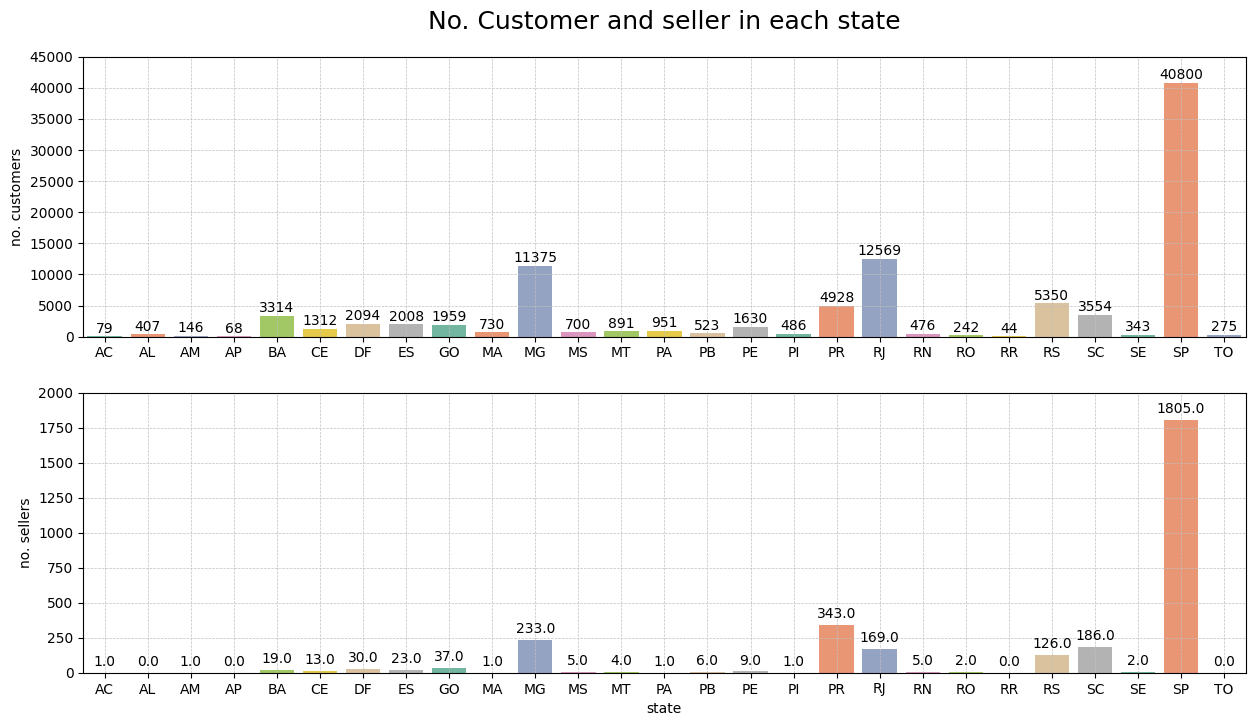

In [18]:
df_cus_state = pd.DataFrame()
df_cus_state['no. customers'] = df['customer_id'].copy()
df_cus_state['state'] = df['customer_state'].copy()
df_cus_state = df_cus_state.drop_duplicates(['no. customers', 'state'])
df_cus_state = df_cus_state.groupby(by='state', sort=True).count()

df_seller_state = pd.DataFrame()
df_seller_state['no. sellers'] = df['seller_id'].copy()
df_seller_state['state'] = df['seller_state'].copy()
df_seller_state = df_seller_state.drop_duplicates(['no. sellers', 'state'])
df_seller_state = df_seller_state.groupby(by='state', sort=True).count()

df_seller_cus = pd.merge(df_cus_state,
                  df_seller_state,
                  on='state',how='left').fillna(0)
df_seller_cus = df_seller_cus.reset_index()

#region Plotting
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.title("No. Customer and seller in each state", pad=20, fontsize=18)

sns.barplot(data=df_seller_cus, x='state', y='no. customers',palette='Set2', hue='state', errorbar=None)
for i in range(len(df_seller_cus['no. customers'])):
    plt.text(i, df_seller_cus['no. customers'][i] + 600, df_seller_cus['no. customers'][i], ha='center')
plt.ylim(0,45000)
plt.grid(axis='both',linestyle='--',linewidth=0.5,color='silver')
plt.xlabel(" ")
plt.subplot(2,1,2)
sns.barplot(data=df_seller_cus, x='state', y='no. sellers',palette='Set2', hue='state', errorbar=None)
for i in range(len(df_seller_cus['no. sellers'])):
    plt.text(i, df_seller_cus['no. sellers'][i] + 50, df_seller_cus['no. sellers'][i], ha='center')
plt.ylim(0,2000)

plt.grid(axis='both',linestyle='--',linewidth=0.5,color='silver')

plt.show()

#endregion


## Segmentation

#### Customer and seller segmentation

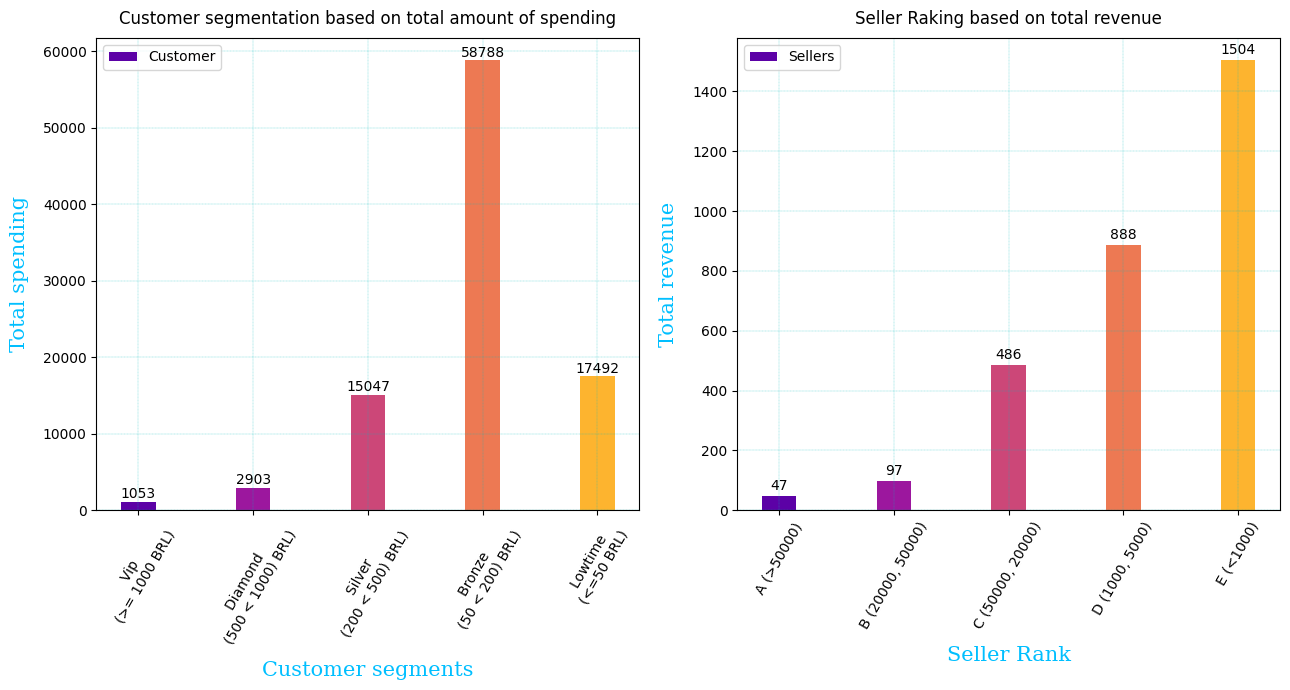

In [19]:
df_cus_segment = df[df["order_status"] == "delivered"]
df_cus_segment = df_cus_segment[["customer_id", "payment"]].groupby("customer_id").sum()

labels = ["Vip \n(>= 1000 BRL)","Diamond \n(500 < 1000) BRL)", "Silver \n(200 < 500) BRL)","Bronze \n(50 < 200) BRL)", "Lowtime \n(<=50 BRL)"]
data = pd.DataFrame(data={"No. customers": [df_cus_segment[(df_cus_segment["payment"] >= 1000)].shape[0], 
                            df_cus_segment[(df_cus_segment["payment"] >= 500) & (df_cus_segment["payment"] < 1000)].shape[0],
                            df_cus_segment[(df_cus_segment["payment"] >= 200) & (df_cus_segment["payment"] < 500)].shape[0],
                            df_cus_segment[(df_cus_segment["payment"] >= 50) & (df_cus_segment["payment"] < 200)].shape[0],
                            df_cus_segment[df_cus_segment["payment"].between(0, 50)].shape[0]]}, index=[1,2,3,4,5])

title = "Customer segmentation based on total amount of spending"
x_axis_name = "Customer segments"
y_axis_name = "Total spending"

plt.figure(figsize=(13,7), dpi=100)
plt.subplots_adjust(hspace=0.7, wspace=0.7)
plt.subplot(1,2,1)
# region Plotting Bar Char

plt.bar(labels, data['No. customers'], width=0.3,label="Customer",color=sns.color_palette('plasma', len(data))) 

for i in range(1,len(data['No. customers']) + 1):
    plt.text(i - 1, data['No. customers'][i] + 500,data['No. customers'][i], ha='center')

plt.grid(True, linewidth=0.2, linestyle='--',color='c') #only for single column
plt.xlabel(x_axis_name,fontdict={'color':'deepskyblue','family':'serif','size':15}, labelpad=10)
plt.ylabel(y_axis_name,fontdict={'color':'deepskyblue','family':'serif','size':15},labelpad=10)
plt.title(title,pad=10)
plt.legend(loc='upper left')
plt.xticks(rotation=60)


# endregion

plt.subplot(1,2,2)

df_seller = df[['seller_id', 'payment']].groupby('seller_id').sum()
df_seller = pd.DataFrame({'Rank': ['A (>50000)','B (20000, 50000)','C (50000, 20000)','D (1000, 5000)','E (<1000)'],
              'No. seller': [
                  df_seller[df_seller['payment'] > 50000].shape[0],
                  df_seller[df_seller['payment'].between(20000, 50000)].shape[0],
                  df_seller[df_seller['payment'].between(5000, 20000)].shape[0],
                  df_seller[df_seller['payment'].between(1000, 5000)].shape[0],
                  df_seller[df_seller['payment'].between(0, 1000)].shape[0],
              ]})

labels = df_seller['Rank']
data = df_seller
title = "Seller Raking based on total revenue"
x_axis_name = "Seller Rank"
y_axis_name = "Total revenue"

# region Plotting seller ranking
plt.bar(labels, data['No. seller'], width=0.3,label="Sellers",color=sns.color_palette('plasma', len(data))) 

for i in range(len(data['No. seller'])):
    plt.text(i, data['No. seller'][i] + 20,data['No. seller'][i], ha='center')

plt.grid(True, linewidth=0.2, linestyle='--',color='c') #only for single column
plt.xlabel(x_axis_name,fontdict={'color':'deepskyblue','family':'serif','size':15}, labelpad=10)
plt.ylabel(y_axis_name,fontdict={'color':'deepskyblue','family':'serif','size':15},labelpad=10)
plt.title(title,loc='center',pad=10)
plt.legend()
plt.xticks(rotation=60)

plt.tight_layout()
plt.show() 
# endregion



#### Top 5 categories has the highest no. product versus the others one?

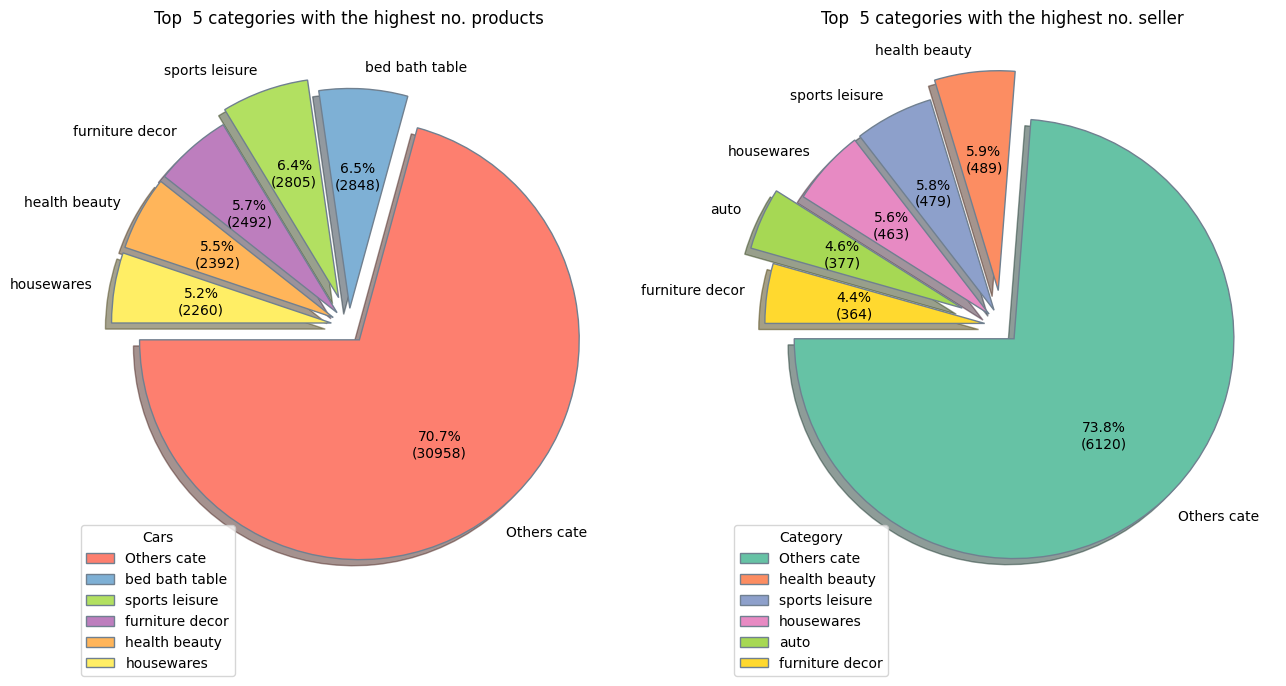

In [20]:
df_pro_cate = df[['category', 'product_id']].groupby('category').nunique()
df_pro_cate = df_pro_cate.reset_index()
df_pro_cate.loc[len(df_pro_cate.index)] = ['Others cate', (df_pro_cate['product_id'].sum() - df_pro_cate['product_id'].head().sum())] 
df_pro_cate = df_pro_cate.sort_values('product_id', ascending=False).head(6)
df_pro_cate = df_pro_cate.reset_index(drop=True)
df_pro_cate

labels = df_pro_cate['category']
data = df_pro_cate['product_id']
x_axis_name = "No. products"
y_axis_name = "Categories"

Spring_Pastels = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]

# region Plot 1
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
 

fig, ax = plt.subplots(1,2,figsize=(13, 7))
wedges, texts, autotexts = ax[0].pie(x=data,
                                  autopct=lambda pct: func(pct, data),
                                  explode=list(map(lambda x : x if (x < 0.24) else 0.08, np.random.random(len(data))))   ,
                                  labels=labels,
                                  shadow=True,
                                  colors=(Spring_Pastels)[:len(data)],
                                  startangle=180,
                                  wedgeprops= {'linewidth': 1, 'edgecolor': "slategray"}, # border
                                  textprops=dict(color="black"))
ax[0].legend(wedges, labels,
          title="Cars",
          loc="center left",
          bbox_to_anchor=(0, 0, 0, 0))

plt.setp(autotexts, size=10, )
ax[0].set_title("Top  5 categories with the highest no. products", pad=20)
# endregion 


df_seller_cate = df[['category', 'seller_id']].groupby('category').nunique()
df_seller_cate = df_seller_cate.reset_index()
df_seller_cate.loc[len(df_seller_cate.index)] = ['Others cate', 
                                                 (df_seller_cate['seller_id'].sum() - df_seller_cate['seller_id'].head().sum())] 
df_seller_cate = df_seller_cate.sort_values('seller_id', ascending=False).head(6)
df_seller_cate = df_seller_cate.reset_index(drop=True)
df_seller_cate

labels = df_seller_cate['category']
data = df_seller_cate['seller_id']
x_axis_name = "No. sellers"
y_axis_name = "Categories"

# region Plot 2
wedges, texts, autotexts = ax[1].pie(x=data,
                                  autopct=lambda pct: func(pct, data),
                                  explode=list(map(lambda x : x if (x < 0.24) else 0.08, np.random.random(len(data))))   ,
                                  labels=labels,
                                  shadow=True,
                                  colors=sns.color_palette('Set2', len(data)),
                                  startangle=180,
                                  wedgeprops= {'linewidth': 1, 'edgecolor': "slategray"}, # border
                                  textprops=dict(color="black"))
ax[1].legend(wedges, labels,
          title="Category",
          loc="center left",
          bbox_to_anchor=(0, 0, 0, 0))

plt.setp(autotexts, size=10, )
ax[1].set_title("Top  5 categories with the highest no. seller", pad=20)
# endregion
plt.axis('off')
plt.tight_layout()
plt.show()



#### Average price MRP in each state

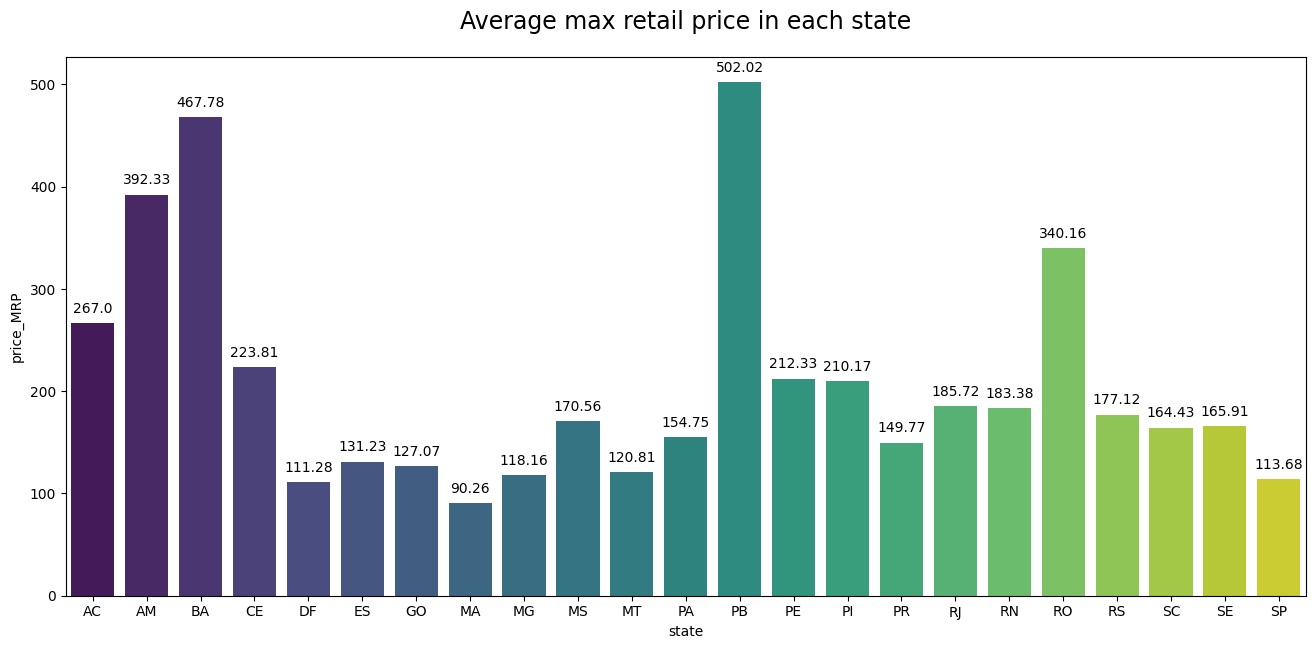

In [21]:
df_ave_price_state = df.groupby(['seller_state']).mean('price_MRP')[[ 'price_MRP']]
df_ave_price_state['price_MRP'] = round(df_ave_price_state['price_MRP'], 2)
df_ave_price_state = df_ave_price_state.reset_index()
df_ave_price_state = df_ave_price_state.rename(columns={'seller_state': 'state'})

plt.figure(figsize=(16,7))
plt.title("Average max retail price in each state", pad=20, fontsize=17)

sns.barplot(data=df_ave_price_state, x='state', y='price_MRP',palette='viridis', hue='state', errorbar=None)
for i in range(len(df_ave_price_state)):
    plt.text(i, df_ave_price_state['price_MRP'][i] + 10, df_ave_price_state['price_MRP'][i], ha='center')
# plt.xticks(rotation=60)/
# plt.axis('off')
# plt.xticks([])
# plt.yticks([])
plt.show()


### The no. product was bought in each state and the no. product in it

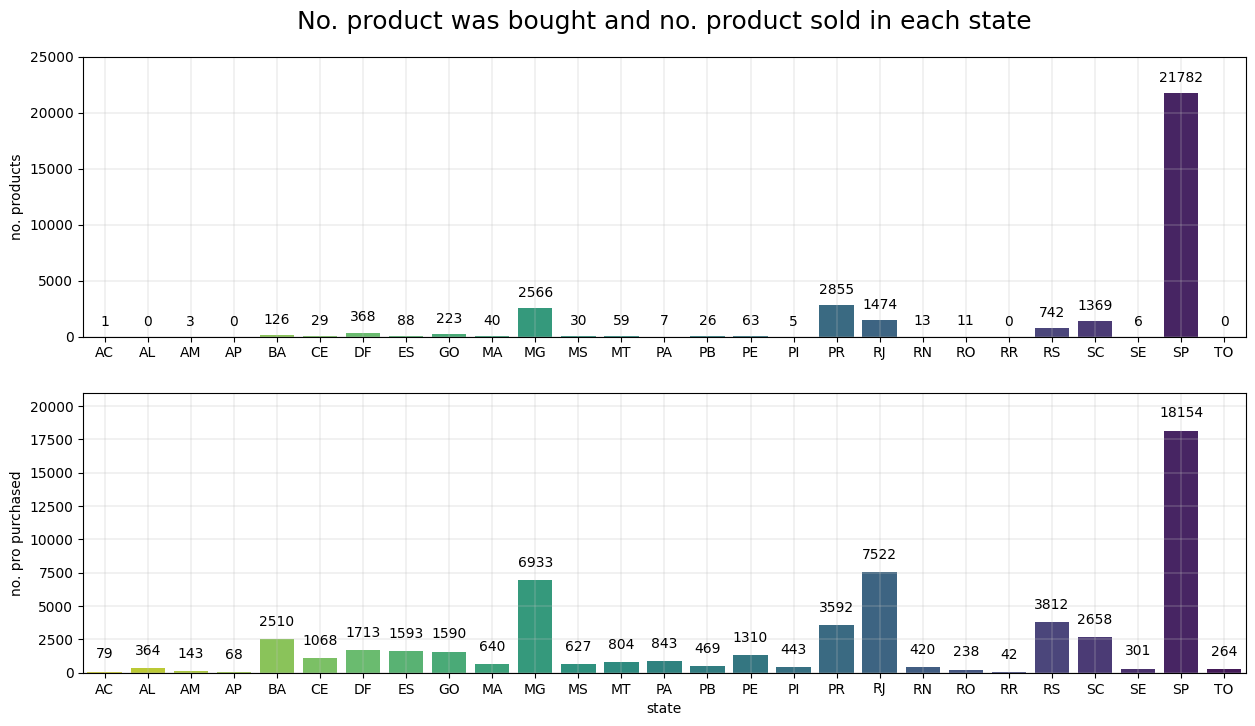

In [22]:
df_pro_sell_state =  pd.merge(
    df[['customer_state', 'product_id']].groupby('customer_state').
    nunique().reset_index().rename(columns={'customer_state':'state', 'product_id':'no. pro purchased'}),
    df[['seller_state', 'product_id']].groupby('seller_state').
    nunique().reset_index().rename(columns={'seller_state':'state', 'product_id':'no. products'}),
    on='state',how='left').fillna(0)
df_pro_sell_state['no. products'] = df_pro_sell_state['no. products'].astype('int32')

# region Plotting
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.title("No. product was bought and no. product sold in each state", pad=20, fontsize=18)

sns.barplot(data=df_pro_sell_state, x='state', y='no. products',palette='viridis_r', hue='state', errorbar=None)
for i in range(len(df_pro_sell_state['no. products'])):
    plt.text(i, df_pro_sell_state['no. products'][i] + 1000 , df_pro_sell_state['no. products'][i], ha='center')
plt.ylim(0,25000)
plt.grid(axis='both',linestyle='-',linewidth=0.3,color='silver')
plt.xlabel(" ")

plt.subplot(2,1,2)
sns.barplot(data=df_pro_sell_state, x='state', y='no. pro purchased',palette='viridis_r', hue='state', errorbar=None)
for i in range(len(df_pro_sell_state['no. pro purchased'])):
    plt.text(i, df_pro_sell_state['no. pro purchased'][i] + 1000 , df_pro_sell_state['no. pro purchased'][i], ha='center')
plt.ylim(0,21000)
plt.grid(axis='both',linestyle='-',linewidth=0.3,color='silver')
plt.show()
# endregion Plotting



## Time series

### No. domestic orders growth

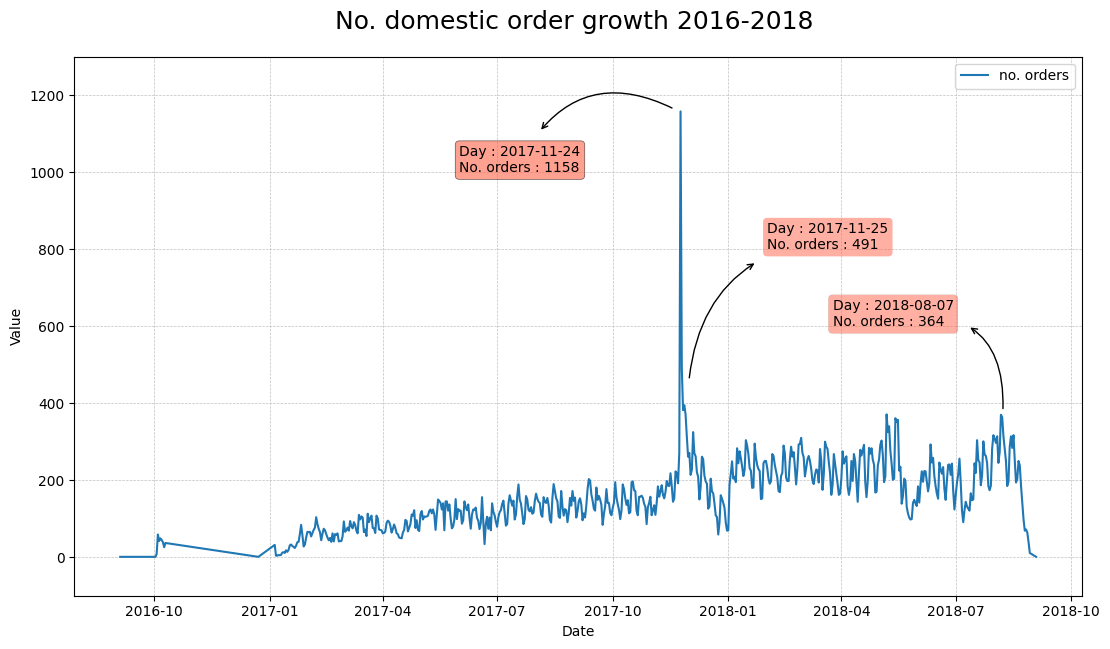

In [23]:
df_gross_domestic = df[['timestamp', 'order_id' ]]
df_gross_domestic.loc[:, 'timestamp'] = df_gross_domestic['timestamp'].dt.date

df_gross_domestic = df_gross_domestic.groupby('timestamp').count().reset_index()

df_gross_domestic.sort_values('order_id').tail(10)

plt.figure(figsize=(13,7))

plt.plot(
    df_gross_domestic['timestamp'],
    df_gross_domestic['order_id'],
    label='no. orders')

plt.annotate('Day : 2017-11-24\nNo. orders : 1158', 
             xy=(pd.to_datetime('2017-11-27'), 1150 ), 
             xytext=(pd.to_datetime('2017-06-01'), 1000 ),
             fontsize=10, fontweight="regular", ## Font settings
             arrowprops=dict(arrowstyle="<-", facecolor="black", connectionstyle="arc3, rad=-0.5",
                             shrinkA=10, shrinkB=10),
                             bbox=dict(boxstyle="round",   ## Bounding box settings
                                        facecolor="tomato", alpha=0.6, linewidth=0.5))
plt.annotate('Day : 2017-11-25\nNo. orders : 491', 
             xy=(pd.to_datetime('2017-11-30	'), 430 ), 
             xytext=(pd.to_datetime('2018-02-01'), 800 ),
             fontsize=10, fontweight="regular", ## Font settings
             arrowprops=dict(arrowstyle="<-", facecolor="black", connectionstyle="arc3, rad=0.4",
                             shrinkA=10, shrinkB=10),
                             bbox=dict(boxstyle="round",   ## Bounding box settings
                                        facecolor="tomato", alpha=0.5, linewidth=0))
plt.annotate('Day : 2018-08-07\nNo. orders : 364', 
             xy=(pd.to_datetime('2018-08-07'), 350 ),
             xytext=(pd.to_datetime('2018-03-25'), 600 ),
             fontsize=10, fontweight="regular", ## Font settings
             arrowprops=dict(arrowstyle="<-", facecolor="black", connectionstyle="arc3, rad=-0.6",
                             shrinkA=10, shrinkB=10),
                             bbox=dict(boxstyle="round",   ## Bounding box settings
                                        facecolor="tomato", alpha=0.5, linewidth=0.1))
plt.xlabel('Date')
plt.grid(axis='both',linestyle='--',linewidth=0.5,color='silver') # đường Lưới
plt.ylabel('Value')
plt.ylim(-100, 1300)
plt.title("No. domestic order growth 2016-2018 ",pad=20,fontsize=18)
plt.legend()
plt.show()


### Monthly Revenue

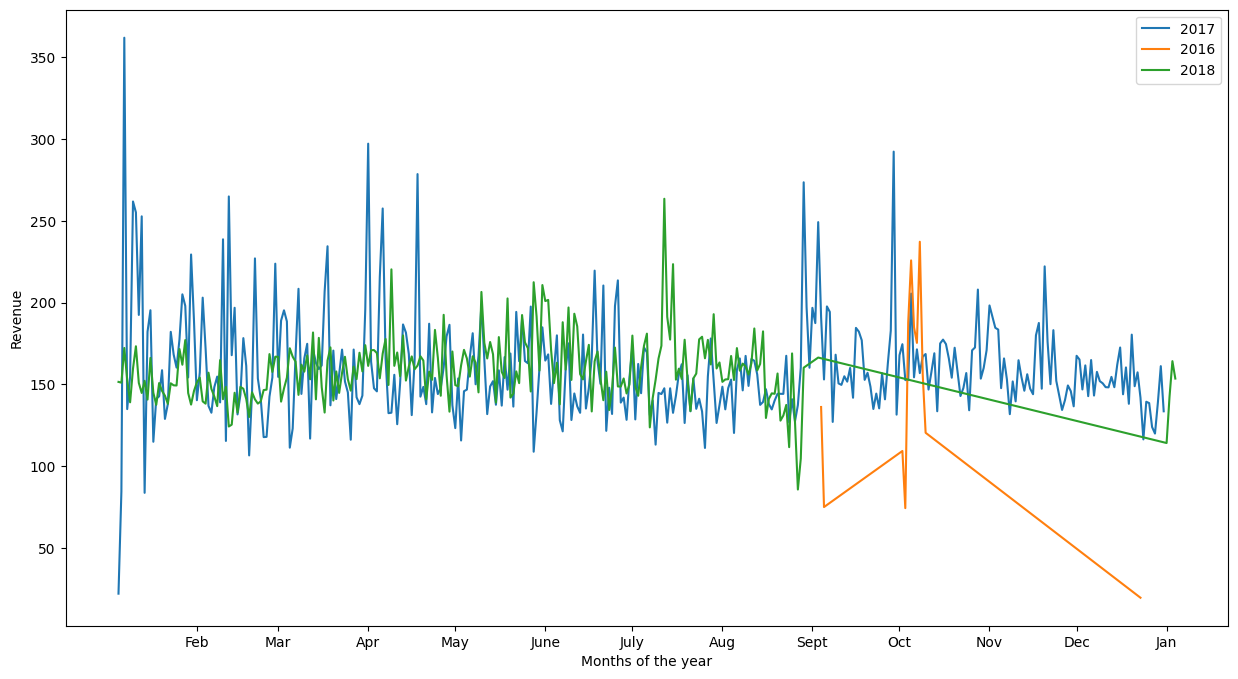

In [24]:
df_monthly_revenue = df[['timestamp','payment']].copy()

df_monthly_revenue_2018 = df_monthly_revenue[df_monthly_revenue['timestamp'].dt.year == 2018]
df_monthly_revenue_2016 = df_monthly_revenue[df_monthly_revenue['timestamp'].dt.year == 2016]
df_monthly_revenue = df_monthly_revenue[df_monthly_revenue['timestamp'].dt.year == 2017]

df_monthly_revenue = df_monthly_revenue.groupby(df_monthly_revenue['timestamp'].dt.date)[['payment']].mean().reset_index()
df_monthly_revenue_2016 = df_monthly_revenue_2016.groupby(df_monthly_revenue_2016['timestamp'].dt.date)[['payment']].mean().reset_index()
df_monthly_revenue_2018 = df_monthly_revenue_2018.groupby(df_monthly_revenue_2018['timestamp'].dt.date)[['payment']].mean().reset_index()

df_monthly_revenue_2018['timestamp'] = df_monthly_revenue_2018['timestamp'].astype('str')
df_monthly_revenue_2016['timestamp'] = df_monthly_revenue_2016['timestamp'].astype('str')
df_monthly_revenue['timestamp'] = df_monthly_revenue['timestamp'].astype('str')

df_monthly_revenue_2018['timestamp'] = df_monthly_revenue_2018['timestamp'].str.replace('2018', '2017')
df_monthly_revenue_2016['timestamp'] = df_monthly_revenue_2016['timestamp'].str.replace('2016', '2017')

df_monthly_revenue

plt.figure(figsize=(15,8))


sns.lineplot(data=df_monthly_revenue, x='timestamp', y='payment', label='2017')
sns.lineplot(data=df_monthly_revenue_2016, x='timestamp', y='payment', label='2016')
sns.lineplot(data=df_monthly_revenue_2018, x='timestamp', y='payment', label='2018')
  
pos = [ '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',  
       '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', 
       '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'] 
lab = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June',  
       'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'] 
plt.xticks( pos, lab) 
  
  
plt.xlabel( 'Months of the year') 
plt.ylabel('Revenue') 

plt.show()


## Geographic maps

#### Load brazil geography map coordinates

In [25]:
with urlopen('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson') as response:
    Brazil = json.load(response)
Brazil

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-73.608178, -7.201942],
       [-72.86963, -7.528509],
       [-72.663035, -7.622899],
       [-72.660926, -7.623753],
       [-72.658816, -7.624607],
       [-72.189139, -7.720115],
       [-72.180896, -7.721791],
       [-72.172652, -7.723466],
       [-72.004612, -7.77447],
       [-71.512459, -7.886919],
       [-71.241081, -7.949829],
       [-70.936887, -8.018713],
       [-70.57532, -8.09556],
       [-70.368997, -8.141024],
       [-69.760758, -8.465852],
       [-69.552806, -8.577996],
       [-69.435256, -8.641215],
       [-69.177713, -8.767576],
       [-68.989072, -8.866179],
       [-68.784481, -8.972206],
       [-68.727521, -8.999689],
       [-68.620055, -9.047748],
       [-68.188419, -9.232315],
       [-67.939822, -9.336832],
       [-67.496119, -9.524192],
       [-67.327502, -9.594168],
       [-67.133347, -9.676444],
       [-67.105347, -

### Preparing data for each state in brazil

In [26]:

df_all_state = pd.merge(df_pro_sell_state,
                        df_ave_price_state,
                        on='state', how='left')
df_cus_state.reset_index(inplace=True)
df_seller_state.reset_index(inplace=True)

df_all_state = pd.merge(df_all_state, df_cus_state, on='state', how='left')
df_all_state = pd.merge(df_all_state, df_seller_state, on='state', how='left').fillna(0)

df_all_state['state'] = ConvertState(df_all_state['state'])
df_all_state['price_MRP'] = df_all_state['price_MRP'].astype('str')
df_all_state['price_MRP'] = df_all_state['price_MRP'] + ' BRL'

df_all_state


,state,no. pro purchased,no. products,price_MRP,no. customers,no. sellers
0,Acre,79,1,267.0 BRL,79,1.0
1,Alagoas,364,0,0.0 BRL,407,0.0
2,Amazonas,143,3,392.33 BRL,146,1.0
3,Amapá,68,0,0.0 BRL,68,0.0
4,Bahia,2510,126,467.78 BRL,3314,19.0
5,Ceará,1068,29,223.81 BRL,1312,13.0
6,Distrito Federal,1713,368,111.28 BRL,2094,30.0
7,Espírito Santo,1593,88,131.23 BRL,2008,23.0
8,Goiás,1590,223,127.07 BRL,1959,37.0
9,Maranhão,640,40,90.26 BRL,730,1.0


In [27]:

fig = px.choropleth(df_all_state, #soybean database
locations = 'state', #define the limits on the map/geography
hover_name = 'state', #the information in the box
geojson = Brazil, #shape information
color = "no. customers", #defining the color of the scale through the database
hover_data =["no. customers","no. sellers","no. products", "no. pro purchased", "price_MRP"],
title = "All state in brazil",
)
fig.update_geos(fitbounds = "locations", visible = False)
fig.update_layout(coloraxis_colorbar=dict(
    thicknessmode="pixels", thickness=10,
    lenmode="pixels", len=150,
    yanchor="top", y=0.8,
    ticks="outside", ticksuffix=" %",
    dtick=5
))
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()
plt.show()

### The whole world map

In [35]:

# fig = px.choropleth_mapbox(
# soybean, #soybean database
# locations = 'Estado', #define the limits on the map/geography
# geojson = Brazil, #shape information
# color = "Produção", #defining the color of the scale through the database
# hover_name = 'Estado', #the information in the box
# hover_data =["Produção","Longitude","Latitude"],
# title = "Produtivida da soja (Toneladas)", #title of the map
# mapbox_style = "carto-positron", #defining a new map style 
# center={"lat":-14, "lon": -55},#define the limits that will be plotted
# zoom = 3, #map view size
# opacity = 0.5, #opacity of the map color, to appear the background
# animation_frame = 'ano' #creating the application based on the yearfig.show()
# )


# plotly.offline.plot(fig, filename = 'Brazil_map.html')

### Correlation